In [19]:
%matplotlib inline

import time

import pandas
import numpy
import sklearn
import sklearn.model_selection
import sklearn.ensemble
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.feature_selection
import sklearn.linear_model

# Dataset

In [85]:
# Return a combined DataFrame, and a dictionary of {featuretype: columns}
def load_data(filename):
    def load_sheet(name):
        df = file.parse(name)
        if 'Index' in df.columns:
            # we index based on row number
            del df['Index']
        else:
            # remove duplicated labels
            del df['Labels']
        return df
    
    file = pandas.ExcelFile(filename)
    dfs = { sheet: load_sheet(sheet) for sheet in file.sheet_names}
    
    # AMT is missing names for columns
    combine = [dfs[k] for k in dfs.keys() if k not in ('AMT')]
    
    combined = dfs['AMT'].copy().add_suffix('-AMT')
    combined = combined.join(combine, lsuffix='', rsuffix='')
    
    # TODO: there are also categories within each wavelet series
    # separated with a _ or -
    feature_categories = {}
    for category, df in dfs.items():
        columns = df.columns
        feature_categories[category] = columns
    
    return combined, feature_categories

fulldata, categories = load_data('DAT300 - CA 1_NEW.xlsx')
assert fulldata.shape[0] == 120, fulldata.shape
assert numpy.count_nonzero(fulldata.Labels.isnull()) == 0, numpy.count_nonzero(fulldata.Labels.isnull())


In [108]:
categories.keys()

dict_keys(['Target', 'AMT', 'WT_originals', 'WT-LLL', 'WT-LLH', 'WT_LHL', 'WT_LHH', 'LBP'])

In [109]:
fulldata.head()

,1-AMT,2-AMT,3-AMT,4-AMT,5-AMT,6-AMT,7-AMT,8-AMT,9-AMT,10-AMT,...,"lbp_24_(24,3)","lbp_25_(24,3)","lbp_2_(24,3)","lbp_3_(24,3)","lbp_4_(24,3)","lbp_5_(24,3)","lbp_6_(24,3)","lbp_7_(24,3)","lbp_8_(24,3)","lbp_9_(24,3)"
0,1.55144,1.51980,1.45847,1.43940,1.43263,1.44893,1.50741,1.54977,1.59866,1.63075,...,53695,468638,17261,15439,18953,22857,24262,26894,27454,29276
1,1.51458,1.47539,1.45449,1.46195,1.44090,1.47846,1.51607,1.53459,1.51287,1.54192,...,53047,462418,16941,15294,18823,22369,24826,27250,28437,30374
2,1.50565,1.46602,1.44400,1.45143,1.42508,1.41574,1.44243,1.47648,1.44198,1.45998,...,53917,469225,17328,15441,19056,22997,24702,26641,27585,29121
3,1.53664,1.50323,1.46508,1.42571,1.43470,1.42078,1.44322,1.45240,1.46457,1.51837,...,53643,465916,16694,15318,18830,22634,24608,26706,27805,29507
4,1.52808,1.47522,1.45618,1.37537,1.37561,1.39346,1.42378,1.46455,1.47553,1.46507,...,48987,456795,15882,14244,17120,20866,23471,26877,28607,31338


In [6]:
fulldata.shape

(128, 1426)

In [194]:
def get_XY(data, feature_columns=None):
    all_feature_columns = list(set(data.columns) - set(['Labels']))
    
    use = data[data.Labels.notna()]
    X = use[all_feature_columns].astype(float)
    if feature_columns is not None:
        X = X.iloc[:,feature_columns]
    y = use.Labels
    return X,y

# Models

In [136]:
kNN = ( sklearn.neighbors.KNeighborsClassifier(), {
       'n_neighbors': [1,2,3,4],
})
RandomForest = ( sklearn.ensemble.RandomForestClassifier(), {
    'n_estimators': [10, 30, 100],
    'min_samples_leaf': [0.01, 0.1],
})
Logistic = ( sklearn.linear_model.LogisticRegression(multi_class='ovr', solver='liblinear'),  {
    'C': [ 0.75, 0.5, 0.25 ],
})

# TODO: add GBT
# MAYBE: add SVM polynomial

models = [
    kNN,
    RandomForest,
    Logistic,
]


## Model evaluation


In [223]:
def evaluate_candidate(dataset, cand, gridcv=5, n_tests=100, seed=0, evalcv=3):
    model, params, features = cand

    # Reduce to subset of features
    X, y = get_XY(dataset, features)
    X = sklearn.preprocessing.RobustScaler().fit_transform(X)
    
    # Decide hyperparameters
    gridsearch_start = time.time()
    grid = sklearn.model_selection.GridSearchCV(model, params, cv=gridcv,
                                                iid=False, refit=True, return_train_score=True)
    grid.fit(X, y)
    estimator = grid.best_estimator_
    
    gridsearch_time = time.time() - gridsearch_start
    
    # Evaluate on a range of test-train splits
    numpy.random.seed(seed)
    test_scores = numpy.array([])
    train_scores = numpy.array([])

    evaluate_start = time.time()
    for rng in numpy.random.randint(0, 1000, size=n_tests):
        X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.4, random_state=rng)

        estimator.fit(X_train, Y_train)

        # FIXME: calculate score across whole test/trainset
        test = sklearn.model_selection.cross_val_score(estimator, X_test, Y_test, cv=evalcv)
        train = sklearn.model_selection.cross_val_score(estimator, X_train, Y_train, cv=evalcv)
        
        test_scores = numpy.concatenate([test_scores, test]) 
        train_scores = numpy.concatenate([train_scores, train])
    evaluate_time =  time.time() - evaluate_start
    
    return test_scores, train_scores, grid.cv_results_, gridsearch_time, evaluate_time

def test_evaluate_candidate():
    all_features = None
    candidate = (sklearn.ensemble.RandomForestClassifier(n_estimators=10), {}, all_features)
    r = evaluate_candidate(fulldata, candidate, n_tests=10)
    assert len(r) == 5
                       
test_evaluate_candidate()

# Feature selection

### Random selection


In [183]:
def random_candidates(models, feature_lengths, n_random=5, max_features=1425):
    candidates = []
    for n_features in feature_lengths:
        random_features = numpy.random.choice(range(max_features), size=(n_random, n_features), replace=False)
        for features in random_features:
            for (m,p) in models:
                candidates.append(( m, p, features, 'random' ))

    return candidates
random_candidates(models, (1,), 5);

### Univariate feature scoring

In [185]:
def feature_score_rf(X, y, n_reps=30):
    importances = numpy.ndarray((n_reps, X.shape[1]))
    # RF tends to ignore redundant features, so average over many runs
    for i in range(0, n_reps):
        rf = sklearn.ensemble.RandomForestClassifier(n_estimators=50, random_state=i)
        rf.fit(X, y)
        s = rf.feature_importances_
        importances[i] = s
        assert numpy.isclose(numpy.sum(s), 1.0), numpy.sum(s)
    
    return numpy.mean(importances, axis=0)

def extract_feature_scores(X, y, scorers):
    ret = []
    X = sklearn.preprocessing.MinMaxScaler().fit_transform(X)
    for f in scorers:
        scores = numpy.array(f(X, y))
        if scores.shape[0] == 2:
            scores = scores[0] # drop p-values
        # normalize it
        scores = scores/scores.sum()
        ret.append(scores)
    return numpy.array(ret)

def select_k_best(scores, n):
    return numpy.argsort(scores)[:n]

def univariate_candidates(models, features_length, scores):
    candidates = []
    for n_features in features_length:
        
        for (m,p) in models:
            # individual scoring functions
            for scores in feature_scores:
                cand = ( m, p, select_k_best(scores, n_features), 'k-best' )
                candidates.append(cand)

            # combined univariate score
            scores = numpy.mean(feature_scores, axis=0)
            assert scores.shape[0] == 1425
            candidates.append((m, p, select_k_best(scores, n_features), 'k-best-mean'))

    return candidates

feature_scorers = [
    feature_score_rf,
    sklearn.feature_selection.mutual_info_classif,
    sklearn.feature_selection.f_classif,
    sklearn.feature_selection.chi2,
]
feature_scores = extract_feature_scores(*get_XY(fulldata), feature_scorers)
assert feature_scores.shape[1] == 1425
univariate_candidates(models, (1,), feature_scores);

In [188]:
# TODO: plot feature scores, each type

In [187]:
feature_scores.shape

(4, 1425)

In [214]:
def all_features_candidates(models):
    candidates = []
    for (m, p) in models:
        candidates.append(( m, p, None, 'all'))
    return candidates

In [216]:
# TODO: implement SFS
# TODO: add baseline candidates (all features)

feature_lengths = (1, 2, 3, 5)

candidates = [] + \
    all_features_candidates(models) + \
    random_candidates(models, feature_lengths, n_random=3) + \
    univariate_candidates(models, feature_lengths, feature_scores)

#numpy.random.shuffle(candidates)

#for cand in candidates:
#    print('cand', cand[2], type(cand[0]), cand[3])

len(candidates)

99

# Evaluate candidates

In [220]:
results = []
for candidate in candidates:
    selector = candidate[3] 
    r = evaluate_candidate(fulldata, candidate[:3], n_tests=10)
    assert len(r) == 5, len(r)
    results.append((candidate, r, selector))

KeyboardInterrupt: 

In [224]:
test_scores = numpy.array([r[1][0] for r in results])
train_scores = numpy.array([r[1][1] for r in results])

def n_features(r):
    f = r[0][2]
    if f is None:
        return None
    else:
        return len(f)

df = pandas.DataFrame({
    'test_mean': test_scores.mean(axis=1),
    'test_std': test_scores.std(axis=1),
    'train_mean': train_scores.mean(axis=1),
    'train_std': train_scores.std(axis=1),
    'n_features': [ n_features(r) for r in results ],
    'features': [ r[0][2] for r in results ],
    'model': [ str(type(r[0][0]).__name__) for r in results ],
    'feature_selector': [ r[2] for r in results ],
    'gridsearch_time': [ r[1][3] for r in results ],
    'evaluation_time': [ r[1][4] for r in results ],
})
df.sort_values(by='test_mean', ascending=False).head(10)

,test_mean,test_std,train_mean,train_std,n_features,features,model,feature_selector,gridsearch_time,evaluation_time
1,0.856728,0.085710,0.912437,0.053595,NaN,None,RandomForestClassifier,all,7.171826,8.300301
2,0.804330,0.102859,0.861321,0.068962,NaN,None,LogisticRegression,all,15.706465,28.781005
0,0.676785,0.123152,0.762794,0.076915,NaN,None,KNeighborsClassifier,all,2.228999,1.015342
9,0.590322,0.142925,0.597795,0.084432,1.0,[651],KNeighborsClassifier,random,0.193654,0.477535
10,0.570114,0.096419,0.585086,0.095850,1.0,[651],RandomForestClassifier,random,4.452227,2.245170
3,0.563626,0.119677,0.596079,0.073031,1.0,[368],KNeighborsClassifier,random,0.196882,0.478912
4,0.555389,0.091202,0.551425,0.074966,1.0,[368],RandomForestClassifier,random,4.338469,2.239923
12,0.513516,0.103008,0.564326,0.103839,2.0,"[1121, 551]",KNeighborsClassifier,random,0.194291,0.478662
13,0.510922,0.081455,0.587507,0.078639,2.0,"[1121, 551]",RandomForestClassifier,random,4.560875,20.380141
7,0.487034,0.086306,0.519009,0.066071,1.0,[638],RandomForestClassifier,random,4.629830,18.666825


In [ ]:
## Best models

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f952bb78c18>,
      dtype=object)

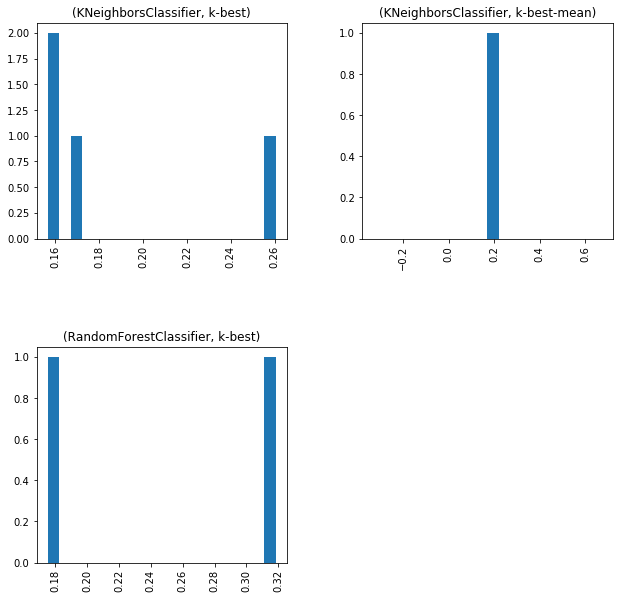

In [162]:
df.hist('test_mean', bins=20, by=['model', 'feature_selector'], figsize=(10,10))